Proyecto 1 Bioseñales y sistemas

Objetivos:

-Aprender a usar Python para la manipulación y visualización básica de señales

-Programar operaciones matemáticas sobres señales

-Hacer comparaciones e inferencias sobre conjuntos de datos


<h4>Se importan las librerías necesarias<h4>

In [7]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg

<h2>Carga de archivos .mat<h2>

In [8]:
ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


<h2>Punto 1<h2>

<h5>Se calcula la densidad espectral de potencia para una señal de EEG utilizando funciones de numpy<h5>

In [132]:
def ecu_spectraldensity(xn,nl,N):
    sums_sk=[]
    w_n=0.42-0.5*np.cos((2*np.pi*nl)/(N-1)) #Se define w_n
    xn=w_n*xn #Se multiplica w_n por la señal
    for k in nl: #Se realiza un for para recorrer los diferentes k de la sumatoria
        s_k=np.abs(np.sum(xn*np.exp((-1j*2*np.pi*k*nl)/N)))**2 #Por último se aplica la fórmula planteada
        sums_sk.append(s_k)
    return np.array(sums_sk)/N

In [133]:
def spectraldensity(xn,epoca=119,paciente=0): 
    """Esta función recibe la matriz con los diferentes archivos, toma un paciente y de este una época
    con esto calcula la densidad espectral de potencia de cada canal"""
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        s_k=ecu_spectraldensity(canal,nl,N)
        sums_k_list.append(s_k)
    return sums_k_list

Ejemplo de lo realizado con el paciente 0 y la época 119, se grafica cada canal


In [134]:
x=spectraldensity(datos_matriz,119,0)


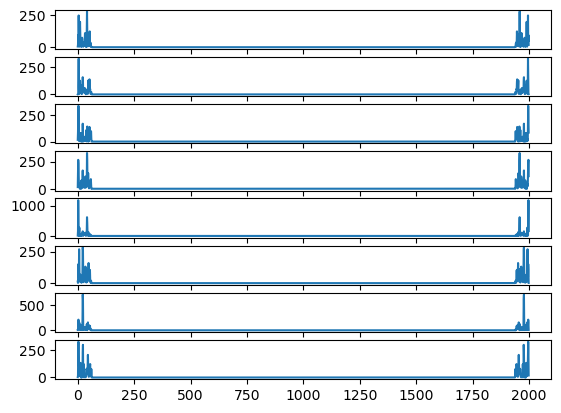

In [135]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()

# Punto 2 
Crear una función que reciba una señal EEG de múltiples épocas, un canal, y devuelva la sumatoria de densidad espectral de potencia, para el rango de frecuencia de 13 a 30 Hz, del promedio de la densidad espectral de potencia de las diferentes épocas de la señal de análisis

In [136]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000,fini=13,ffin=30):
    """Esta funcion toma un paciente de la matriz de datos y calcula la sumatoria para sk"""
    data=data[paciente][canal,:,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.arange(N)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(0,fs,num=N)
    return s_k,frecuencia

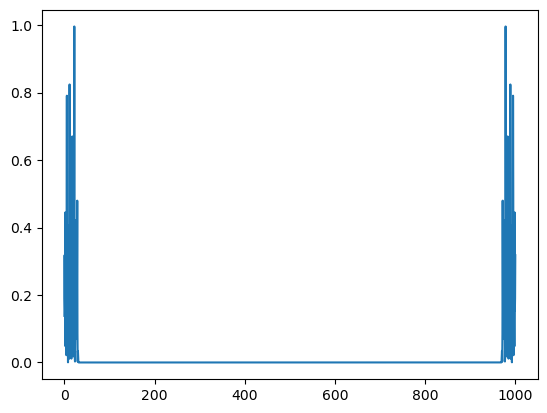

In [137]:
x,f=sum_spectraldensity(datos_matriz,0,0)
plt.plot(f,x)

Se acota según el rango deseado (13Hz a 30Hz)

In [138]:
def spectralrange(x,f,ini=13,end=30):
    bf=np.where((f>=13) &(f<=30))
    f=f[bf]
    x=x[bf]
    return f,x

Se grafica un ejemplo

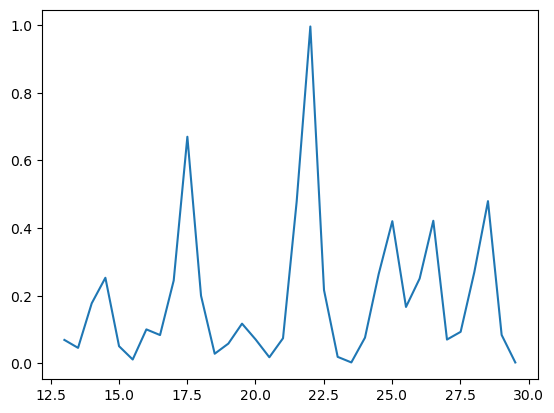

In [139]:
f,x=spectralrange(x,f,13,30)
plt.plot(f,x)

# Punto 3
Crear una función  que  reciba una señal EEG de múltiples canales y múltiples épocas y devuelva los valores calculados en el punto para cada  canal por separado

In [235]:
def PSD(data,paciente=0):
    sums_k_list=[]
    canales=np.arange(len(data[paciente][:,0,0]))

    for canal in canales:
        s_k,f=sum_spectraldensity(data,canal,paciente)
        f,x=spectralrange(s_k,f)
        
        s_k=np.sum(x)
        sums_k_list.append(s_k)
    return sums_k_list

In [236]:
X=PSD(datos_matriz)

In [142]:
print(X)

[6.588136262156796, 7.170274084597011, 8.488089358209756, 6.342503451805725, 6.311502654693775, 8.79407395065854, 7.26157308045821, 11.369824100507422]


# Punto 4
Rutina que aplique sobre todos los archivos de la base de datos la rutina 3 y almacene los resultados en un dataframe donde se pueda discriminar sujeto, control o paciente y el promedio de densidad espectral de potenciapara cada canal

In [143]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=PSD(datos_matriz,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=PSD(datos_parkinson,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [108]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [169]:

df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,6.588136,7.170274,8.488089,6.342503,6.311503,8.794074,7.261573,11.369824
2,Control,6.937180,4.682711,2.739435,2.267806,4.730358,13.290693,11.449452,12.883728
3,Control,4.018534,3.599051,5.457592,2.222556,5.556907,2.553184,2.944823,4.609807
4,Control,9.762080,6.623699,9.884979,11.724950,14.610523,22.633438,15.156428,12.204539
5,Control,5.309109,6.728339,8.453612,8.823974,8.370769,10.319439,9.530214,9.589701
6,Control,6.184479,5.465086,4.825497,3.054241,3.661056,4.980654,5.412684,6.552773
7,Control,4.139802,2.935076,3.841803,4.263166,5.032301,7.541838,6.499612,9.207845
8,Control,3.629768,2.767345,2.806591,2.857862,5.790350,6.864858,6.927915,9.292365
9,Control,1.926986,2.042166,2.071883,1.542974,1.392093,12.023476,8.962724,8.070981


Se crean archivos cvs para 

In [170]:
df.to_csv("Tabla.cvs",index=False)

In [9]:
df=pd.read_csv("Tabla.cvs")

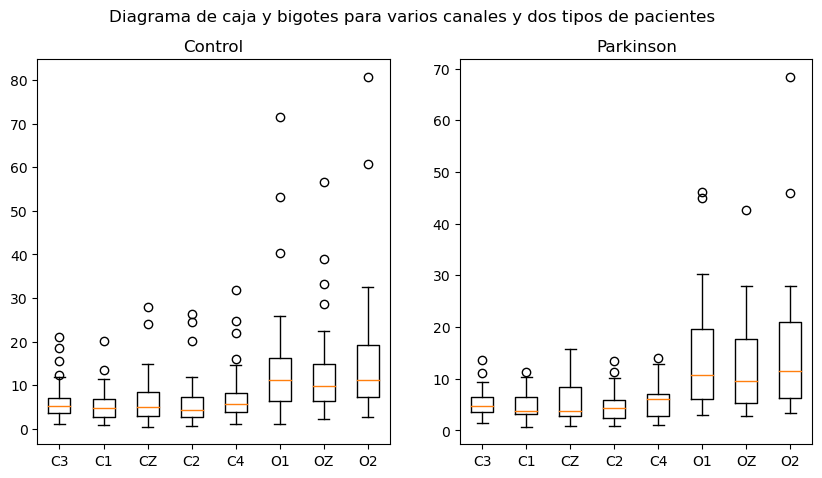

In [10]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

Filtro datos atípicos, usando el promedio de todos los datos

In [11]:
control, parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

#filtrado para control

columna=control.columns[8]
locateado=(control[columna]>30).values

control.loc[locateado,columna]=None
prom1=control[columna].mean()
control=control.fillna(prom1)

columna=control.columns[7]
locateado=(control[columna]>25).values
control.loc[locateado,columna]=None
prom1=control[columna].mean()
control=control.fillna(prom1)

columna=control.columns[6]
locateado=(control[columna]>30).values
control.loc[locateado,columna]=None
prom1=control[columna].mean()
control=control.fillna(prom1)

columna=control.columns[5]
locateado=(control[columna]>20).values
control.loc[locateado,columna]=None
prom1=control[columna].mean()
control=control.fillna(prom1)

# filtrado para parkinson

columna=parkinson.columns[8]
locateado=(parkinson[columna]>40).values
parkinson.loc[locateado,columna]=None
prom1=parkinson[columna].mean()
parkinson=parkinson.fillna(prom1)

columna=parkinson.columns[6]
locateado=(parkinson[columna]>26).values
parkinson.loc[locateado,columna]=None
prom1=parkinson[columna].mean()
parkinson=parkinson.fillna(prom1)

columna=parkinson.columns[7]
locateado=(parkinson[columna]>30).values
parkinson.loc[locateado,columna]=None
prom1=parkinson[columna].mean()
parkinson=parkinson.fillna(prom1)


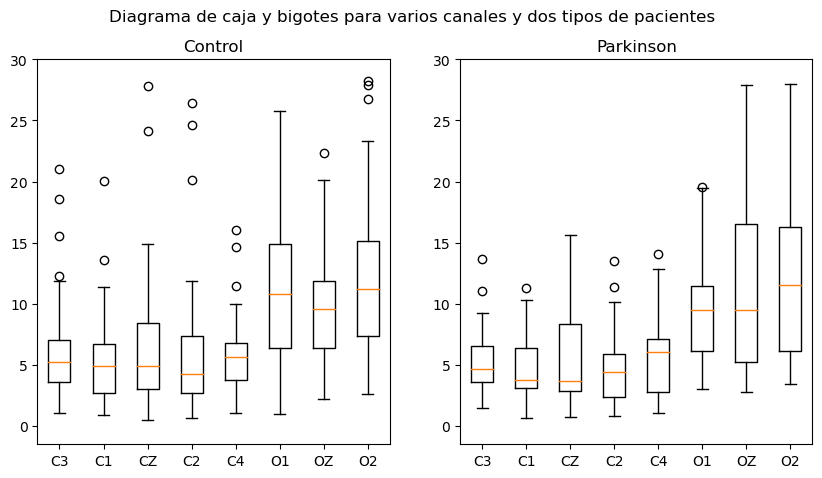

In [12]:
dataframes = control,parkinson
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.5, 30])
    
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [92]:
df=pd.concat(dataframes,ignore_index=True)
df.to_csv("Datos_filtrados.cvs",index=False)

In [15]:
df=pd.read_csv("Datos_filtrados.cvs")

Se crea una funcion para ver si el conjunto de datos están normalmente distribuidos. Esto con el fin de saber que tipo de pruebas realizar para analizar los datos

In [16]:
def check_normality(data):
    '''Check if the distribution is normal.'''
    
    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
    _ = stats.probplot(data, plot=plt)
    plt.show()

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['Omnibus']    = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk']    = stats.shapiro(data)
    
    print('--------------------------------')
    print('p-values for all {0} data points:'.format(len(data)))
    print(pVals)
    print('--------------------------------')
    
    if pVals['Omnibus'] > 0.05:
        print('Data are normally distributed')
    elif pVals['Shapiro-Wilk'] > 0.05:
        print('Data are normally distributed')
    else:
        print("Data arent normally distribuited")
    # --- >>> STOP stats <<< ---
    print('--------------------------------')
    
    return [pVals['Shapiro-Wilk'],pVals['Omnibus']]

For chanel: PSD_C3


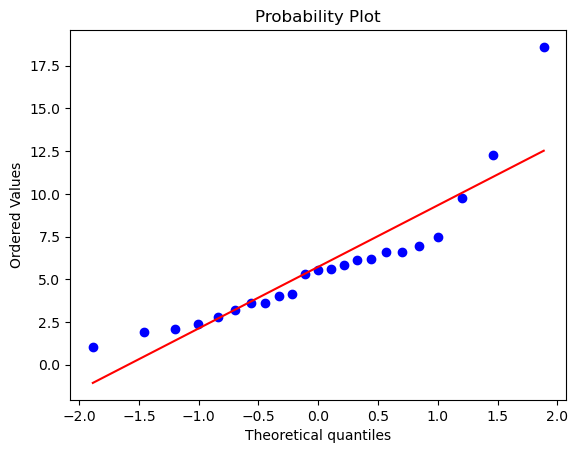

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.000036
Shapiro-Wilk    0.001181
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C1


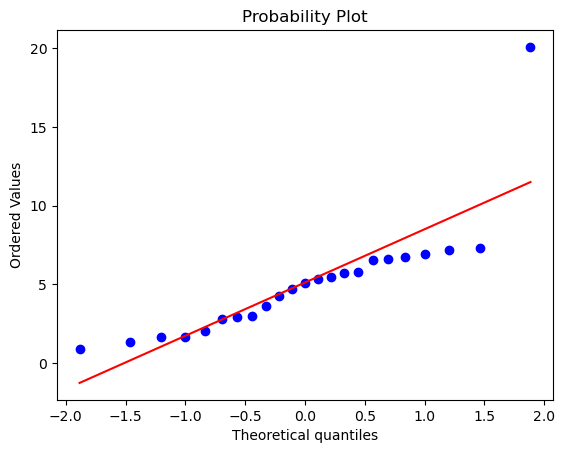

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus              0.0
Shapiro-Wilk    0.000032
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_CZ


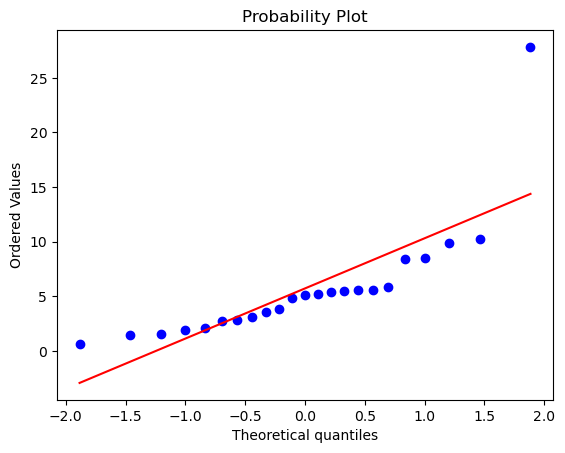

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus              0.0
Shapiro-Wilk    0.000005
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C2


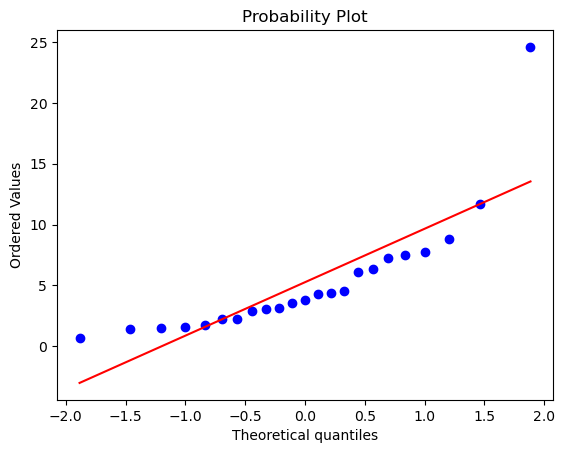

--------------------------------
p-values for all 23 data points:
0               p-value
Omnibus             0.0
Shapiro-Wilk    0.00002
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C4


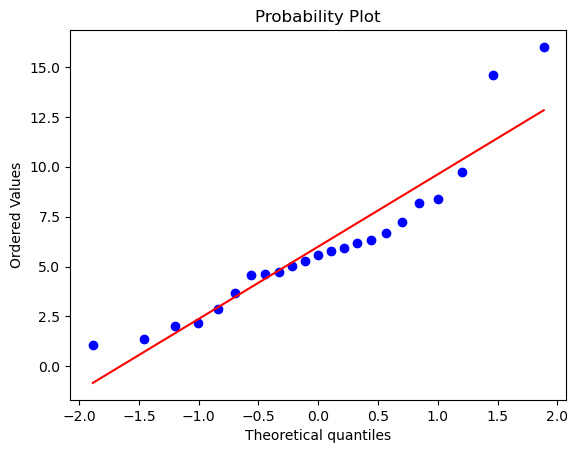

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.006466
Shapiro-Wilk    0.012334
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_O1


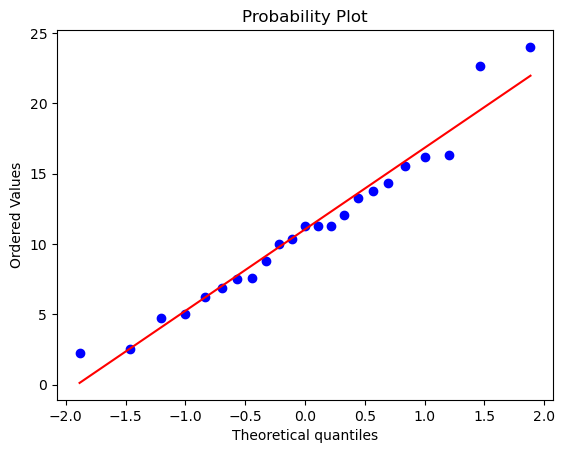

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus          0.37442
Shapiro-Wilk    0.448179
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_OZ


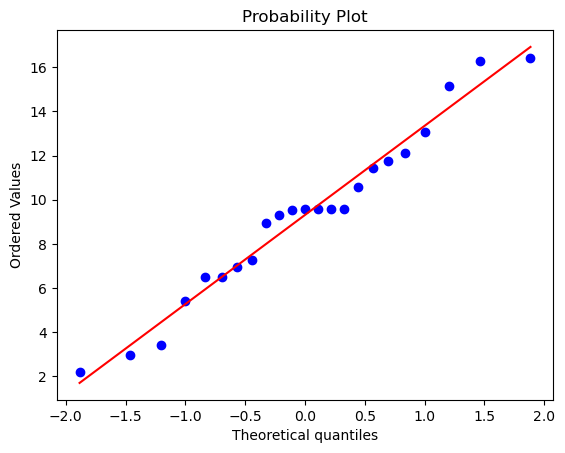

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.984138
Shapiro-Wilk    0.589193
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


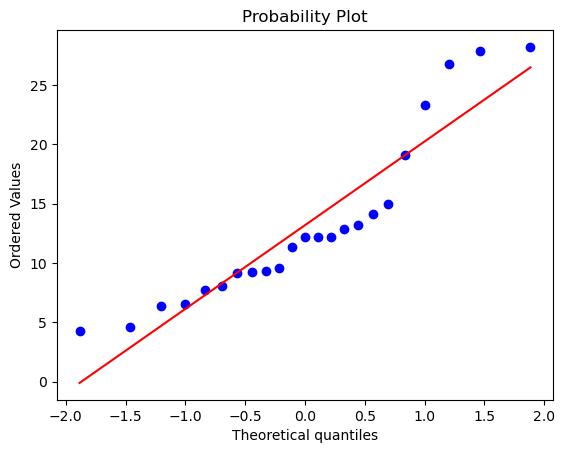

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.094778
Shapiro-Wilk    0.006073
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [17]:
names=df.columns.values
pcontrol=sum(df["Estado"]=="Parkinson")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    print("For chanel: "+i)
    c=df.loc[0:pcontrol-1,i]
    x=check_normality(c)

For chanel: PSD_C3


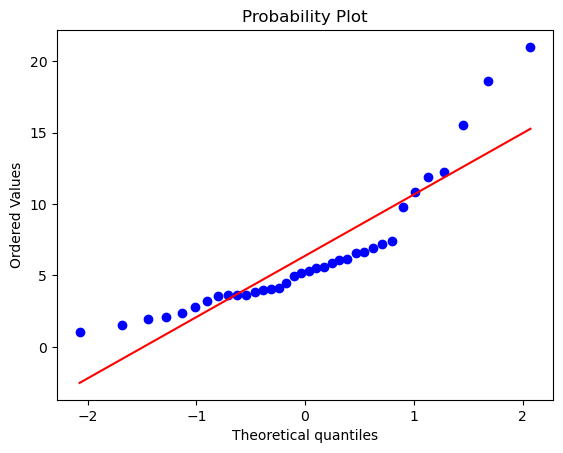

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000059
Shapiro-Wilk    0.000043
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C1


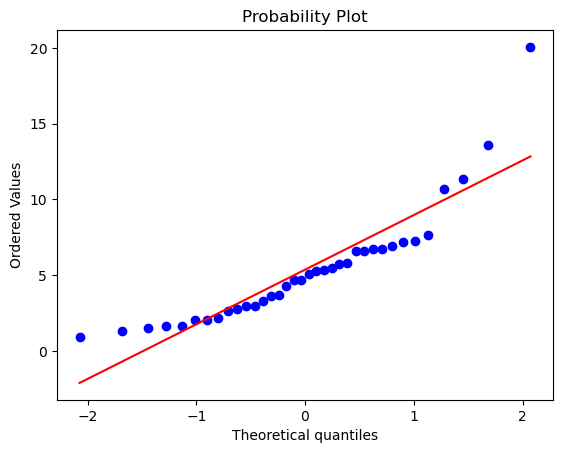

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000002
Shapiro-Wilk    0.000079
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_CZ


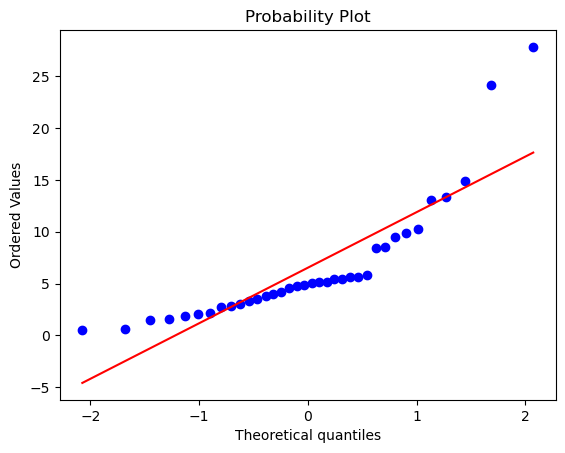

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000001
Shapiro-Wilk    0.000003
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C2


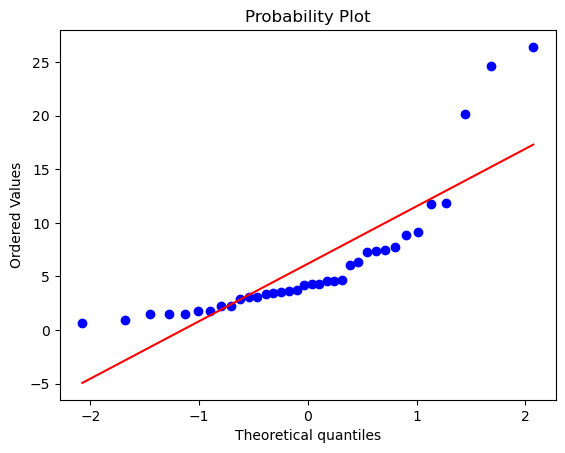

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000001
Shapiro-Wilk    0.000001
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C4


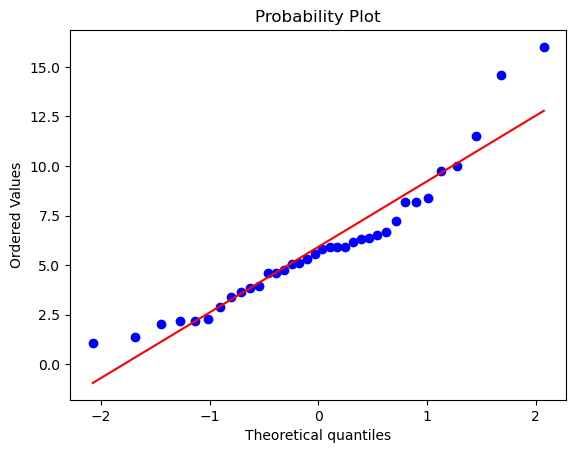

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.002668
Shapiro-Wilk     0.00671
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_O1


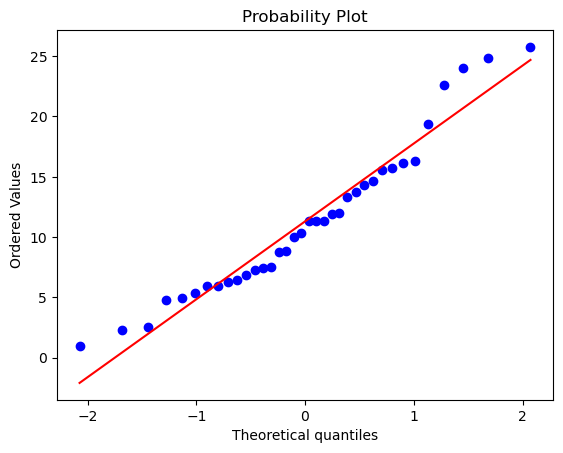

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.214793
Shapiro-Wilk    0.078094
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_OZ


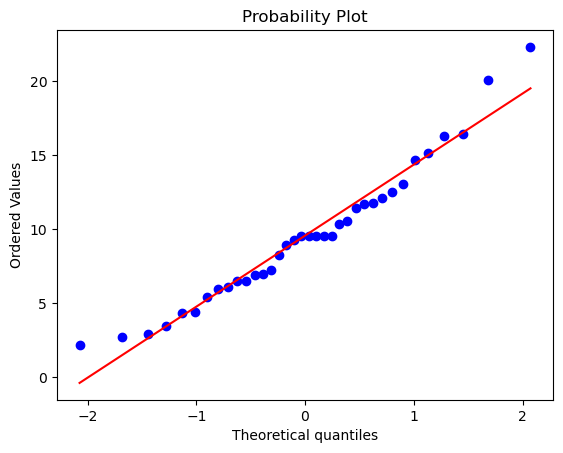

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.139727
Shapiro-Wilk    0.202481
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


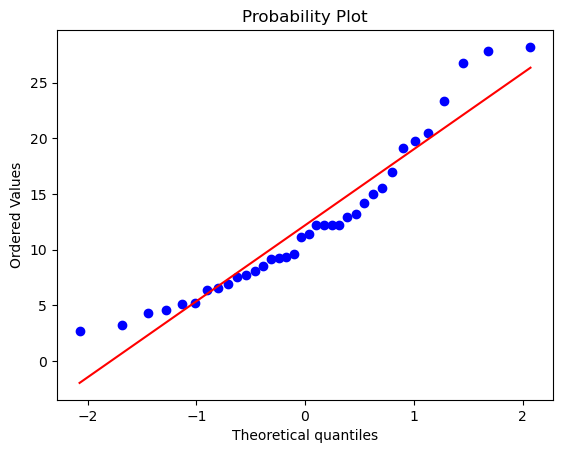

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.067281
Shapiro-Wilk    0.010982
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [18]:
names=df.columns.values
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    print("For chanel: "+i)
    c=df.loc[0:pcontrol-1,i]
    x=check_normality(c)

Verificar Homocedasticidad

In [19]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
for i in names[1:]:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con],p_valor))
  con+=1
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
  else:
    print("Los datos no son homocedásticos.")

Canal Estado p=0.314 
Los datos son homocedásticos.
Canal PSD_C3 p=0.470 
Los datos son homocedásticos.
Canal PSD_C1 p=0.591 
Los datos son homocedásticos.
Canal PSD_CZ p=0.327 
Los datos son homocedásticos.
Canal PSD_C2 p=0.377 
Los datos son homocedásticos.
Canal PSD_C4 p=0.067 
Los datos son homocedásticos.
Canal PSD_O1 p=0.064 
Los datos son homocedásticos.
Canal PSD_OZ p=0.639 
Los datos son homocedásticos.


Prueba T


In [21]:
con=0
for i in names[1:]:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  print("Canal:%s"%names[con+1])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('Same distribution (fail to reject H0)')
  else:
        print('Different distribution (reject H0)')
  display(t)

Canal:PSD_C3
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.849787,57,two-sided,0.398999,"[-1.24, 3.07]",0.226841,0.364,0.133007


Canal:PSD_C1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.634362,57,two-sided,0.528383,"[-1.29, 2.48]",0.169335,0.319,0.095624


Canal:PSD_CZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.749526,57,two-sided,0.456623,"[-1.77, 3.88]",0.200077,0.341,0.114163


Canal:PSD_C2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.984843,57,two-sided,0.328863,"[-1.42, 4.16]",0.262892,0.404,0.162389


Canal:PSD_C4
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.101076,57,two-sided,0.919845,"[-1.78, 1.96]",0.026981,0.271,0.051132


Canal:PSD_O1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.163852,57,two-sided,0.249333,"[-1.28, 4.84]",0.310677,0.473,0.208301


Canal:PSD_OZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.185377,57,two-sided,0.240787,"[-4.77, 1.22]",0.316423,0.483,0.21434


Canal:PSD_O2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.045009,57,two-sided,0.964258,"[-3.82, 3.65]",0.012015,0.27,0.050224


# Normalizacion

In [72]:
df2=df.copy()
data=np.log(df2.iloc[:,1:9])
data=data.join(pd.DataFrame(df2.iloc[:,0].values,columns=["Estado"]))
a=list(data.columns)
a[0],a[8]=a[8],a[0]
data=data[a]

In [73]:
df=data

In [74]:
df.to_csv("Datos_Normalizados.cvs",index=False)

In [96]:
df=pd.read_csv("Datos_Normalizados.cvs")

In [99]:
df=df.drop(np.where(np.logical_and( df["Estado"]=="Parkinson",df[df.columns[2]]<0).values)[0])
df=df.reset_index(drop=True)

In [100]:
df=df.drop(np.where(np.logical_and( df["Estado"]=="Control",df[df.columns[2]]<0).values)[0])
df=df.reset_index(drop=True)

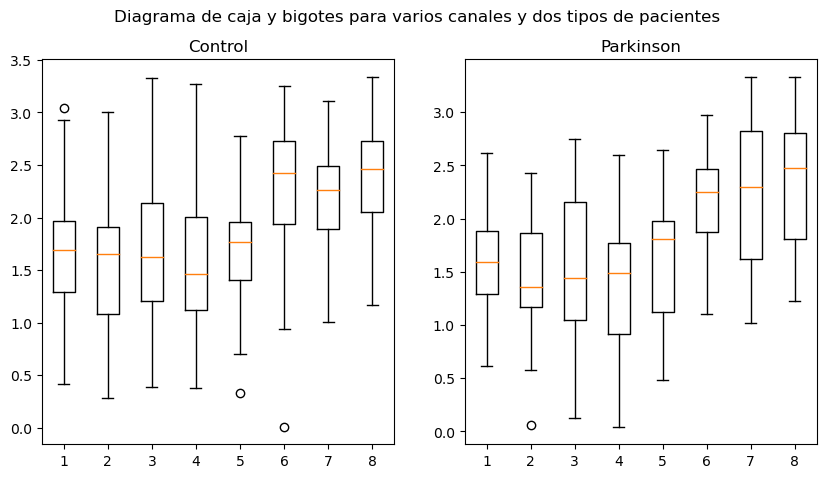

In [101]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']

# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

Se vueve a checkear normalidad


For chanel: PSD_C1


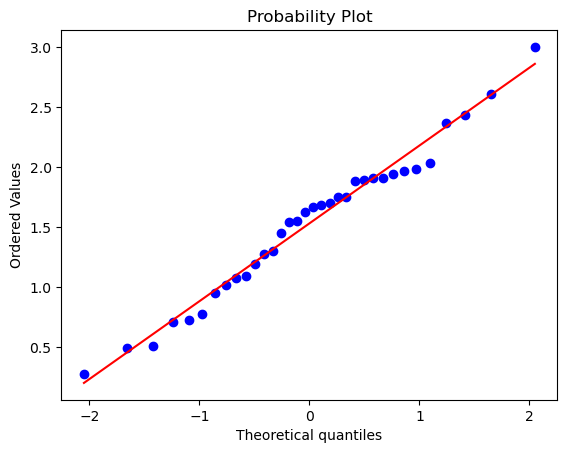

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.997452
Shapiro-Wilk    0.776679
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_CZ


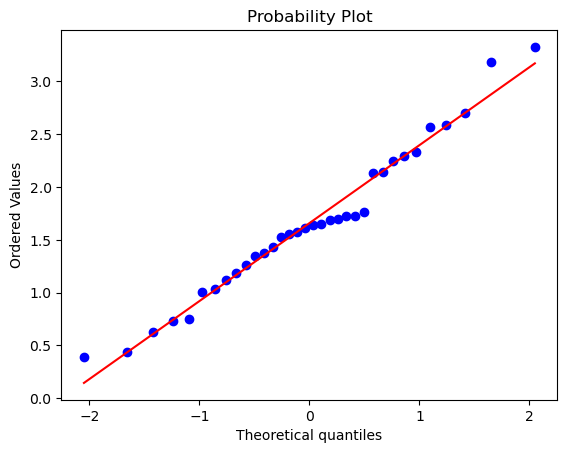

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.601016
Shapiro-Wilk    0.511513
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C2


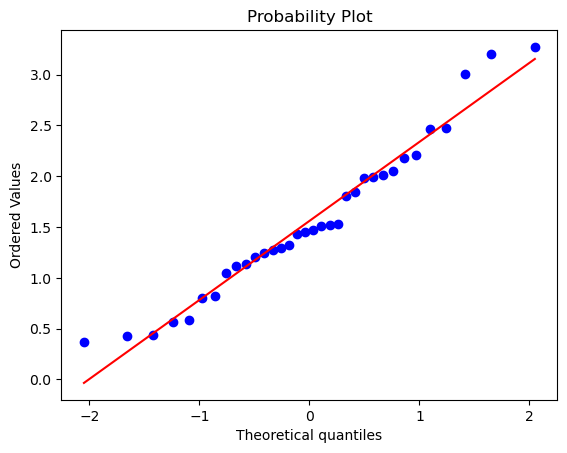

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.423285
Shapiro-Wilk    0.215627
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C4


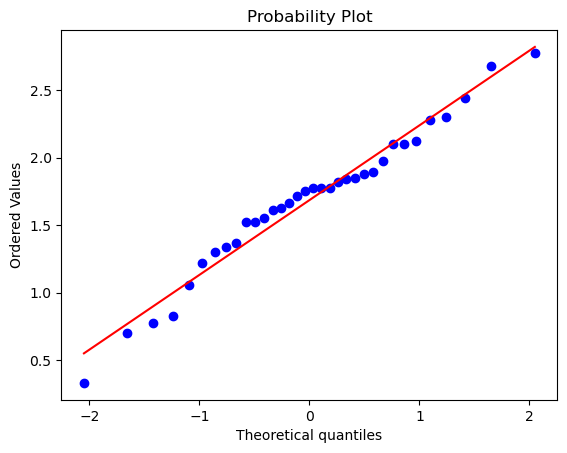

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.465799
Shapiro-Wilk    0.590373
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O1


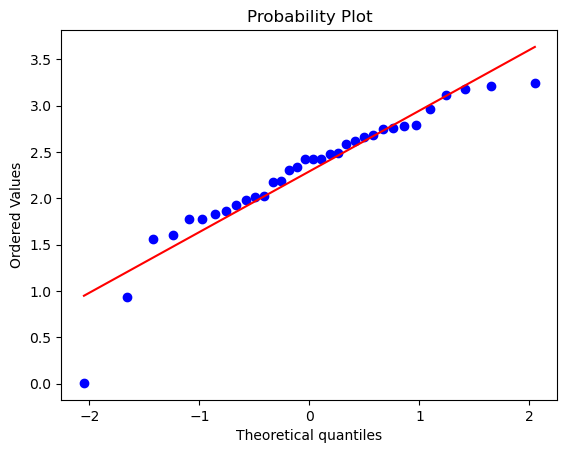

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.000621
Shapiro-Wilk    0.010802
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_OZ


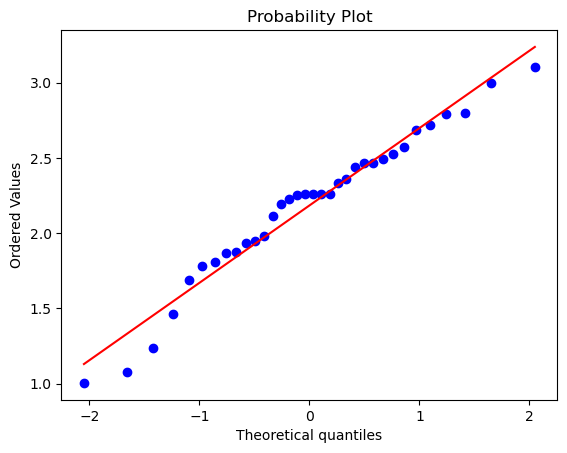

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.307074
Shapiro-Wilk    0.322225
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


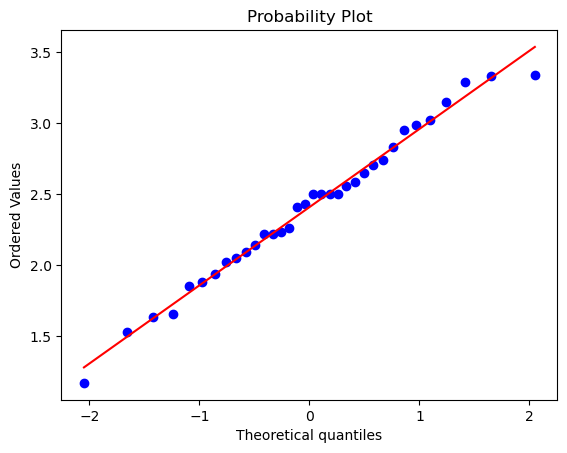

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.909062
Shapiro-Wilk    0.884065
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C3


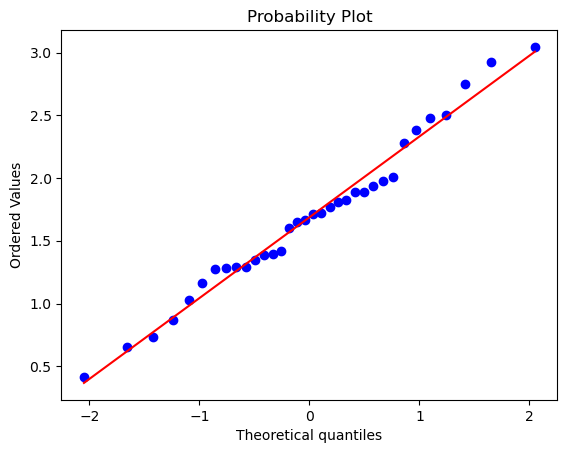

--------------------------------
p-values for all 34 data points:
0                p-value
Omnibus         0.807567
Shapiro-Wilk    0.775722
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [102]:
names=df.columns.values
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    print("For chanel: "+i)
    c=df.loc[0:pcontrol-1,i]
    x=check_normality(c)

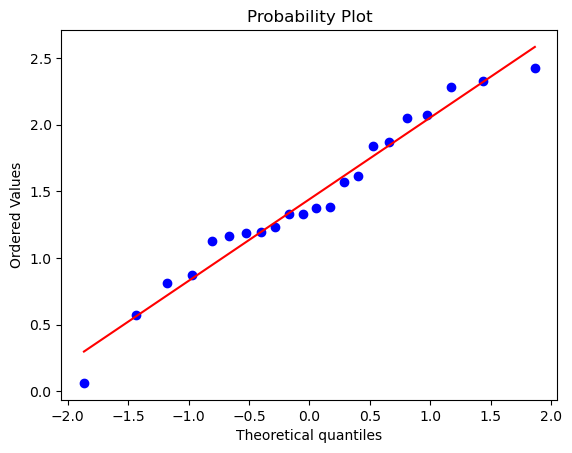

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.843667
Shapiro-Wilk    0.686326
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


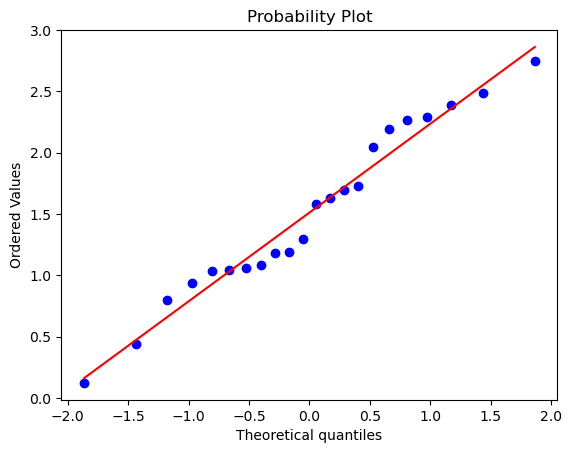

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.736053
Shapiro-Wilk    0.627906
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


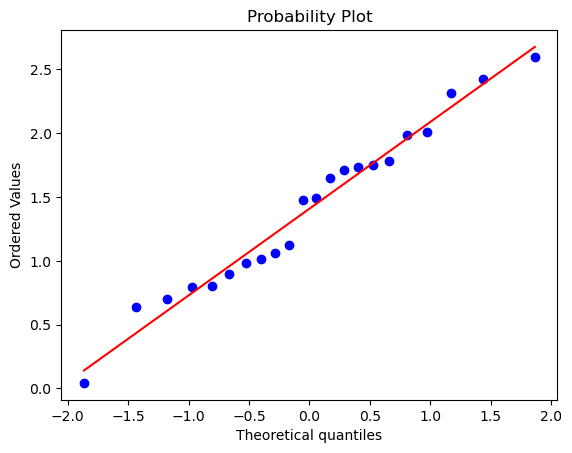

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.893577
Shapiro-Wilk    0.774874
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


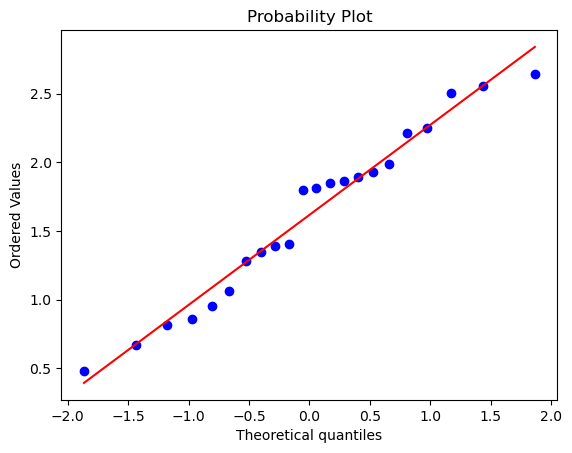

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.427958
Shapiro-Wilk    0.489536
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


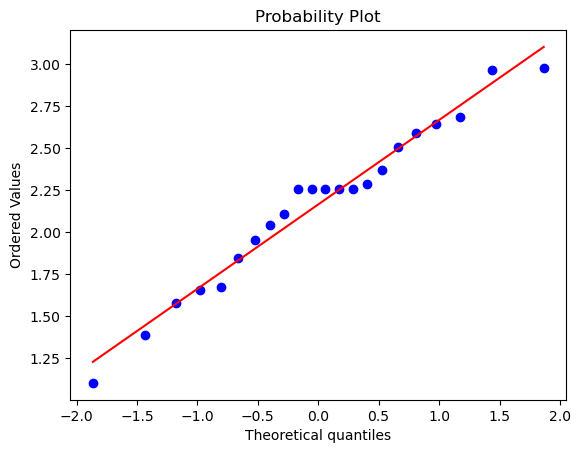

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.761745
Shapiro-Wilk    0.712581
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


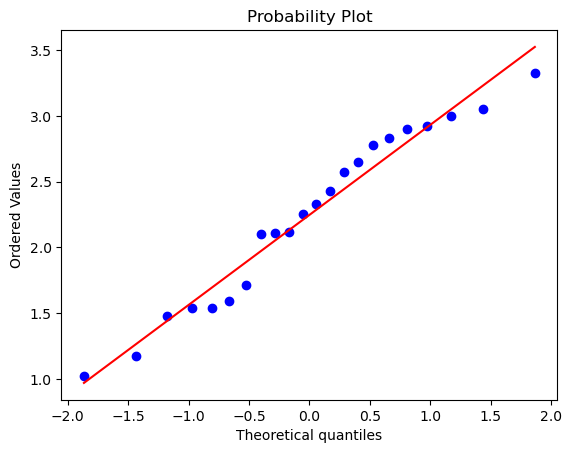

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.309359
Shapiro-Wilk    0.398747
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


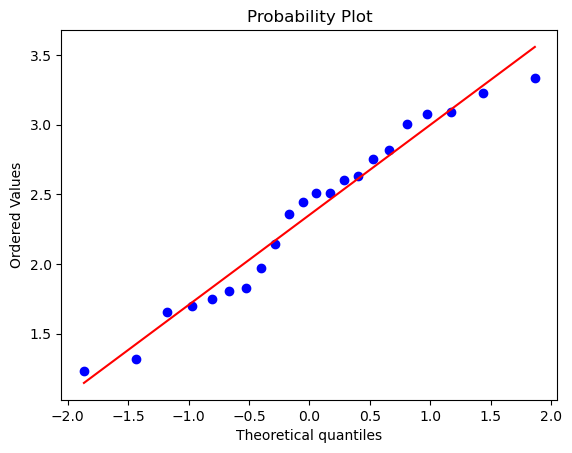

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.320132
Shapiro-Wilk    0.434442
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


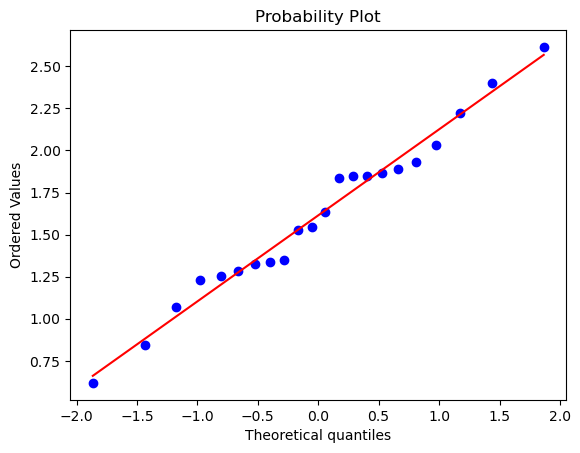

--------------------------------
p-values for all 22 data points:
0                p-value
Omnibus         0.994368
Shapiro-Wilk    0.947869
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [103]:
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes Parkinson
    c=df.loc[pcontrol:len(df),i]
    x=check_normality(c)

In [104]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
for i in names[1:]:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con],p_valor))
  con+=1
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
  else:
    print("Los datos no son homocedásticos.")

Canal Estado p=0.675 
Los datos son homocedásticos.
Canal PSD_C1 p=0.721 
Los datos son homocedásticos.
Canal PSD_CZ p=0.707 
Los datos son homocedásticos.
Canal PSD_C2 p=0.244 
Los datos son homocedásticos.
Canal PSD_C4 p=0.291 
Los datos son homocedásticos.
Canal PSD_O1 p=0.066 
Los datos son homocedásticos.
Canal PSD_OZ p=0.316 
Los datos son homocedásticos.
Canal PSD_O2 p=0.376 
Los datos son homocedásticos.


Se aplica la prueba T ya que los datos son Homocedasticos y tienen una distribución normal


In [105]:
con=0
for i in names[1:]:
  c=df.loc[:,i]
  p=dfp.loc[:,i] 
  print("Canal:%s"%names[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('Same distribution (fail to reject H0)')
  else:
        print('Different distribution (reject H0)')
  display(t)

NameError: name 'dfp' is not defined